## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

## Load the Data

In [2]:
train_data = pd.read_csv('Dataset/Merged_dataset/merged_file.csv', names=['time', 'voltage', 'el_power'])
test_data = pd.read_csv('Dataset/Merged_dataset/test_merged_file.csv', names=['time', 'voltage', 'el_power'])

## Data Preprocessing

In [3]:
# Convert 'time', 'voltage', and 'el_power' columns to float, invalid entries will be set to NaN.
train_data['time'] = pd.to_numeric(train_data['time'], errors='coerce')
train_data['voltage'] = pd.to_numeric(train_data['voltage'], errors='coerce')
train_data['el_power'] = pd.to_numeric(train_data['el_power'], errors='coerce')

test_data['time'] = pd.to_numeric(test_data['time'], errors='coerce')
test_data['voltage'] = pd.to_numeric(test_data['voltage'], errors='coerce')
test_data['el_power'] = pd.to_numeric(test_data['el_power'], errors='coerce')

In [4]:
# Handle missing values by dropping rows with NaN in the training data
train_data = train_data.dropna()
test_data = test_data.dropna()

## Split Features and Target for Training Data

In [5]:
X_train = train_data[['time', 'voltage']]
y_train = train_data['el_power']

## Split Data into Training and Validation Sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Data Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_data[['time', 'voltage']])

## Defining parameter space

In [8]:
# Define the parameter grid for XGBoost with valid ranges
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.2),  # Learning rate
    'max_depth': randint(3, 10),  # Maximum depth of the tree
    'subsample': uniform(0.5, 0.5),  # Subsample ratio of the training data (0.5 to 1.0)
    'colsample_bytree': uniform(0.5, 0.5),  # Subsample ratio of features (0.5 to 1.0)
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'reg_alpha': uniform(0, 0.5),  # L1 regularization
    'reg_lambda': uniform(0.5, 1.5)  # L2 regularization
}

In [9]:
# Initialize the XGBRegressor
xgb_model = XGBRegressor(random_state=42)

In [10]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=50,  # Number of different combinations to try
    scoring='neg_root_mean_squared_error',  # Use RMSE as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=2, 
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [11]:
# Perform RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E5A63DB250>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E5A1B6D9A0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E5A63E70A0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [12]:
# Output the best hyperparameters found
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best RMSE score: {-random_search.best_score_:.4f}")

Best hyperparameters: {'colsample_bytree': 0.8974056517708242, 'gamma': 0.25131854655259606, 'learning_rate': 0.12538077692527183, 'max_depth': 3, 'n_estimators': 552, 'reg_alpha': 0.11509263412077764, 'reg_lambda': 1.2487900698271286, 'subsample': 0.7860020996045916}
Best RMSE score: 286.2059


## Initialize and Train the XGBoost Model

In [13]:
# Train the model with the best hyperparameters
best_xgb_model = random_search.best_estimator_

In [14]:
# Fit the best model to the entire training set
best_xgb_model.fit(X_train_scaled, y_train, 
                   eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)], 
                   eval_metric='rmse', 
                   early_stopping_rounds=10, 
                   verbose=False)

C:\Users\TSA\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\TSA\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8974056517708242, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.25131854655259606,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12538077692527183,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=552, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Learning Curves

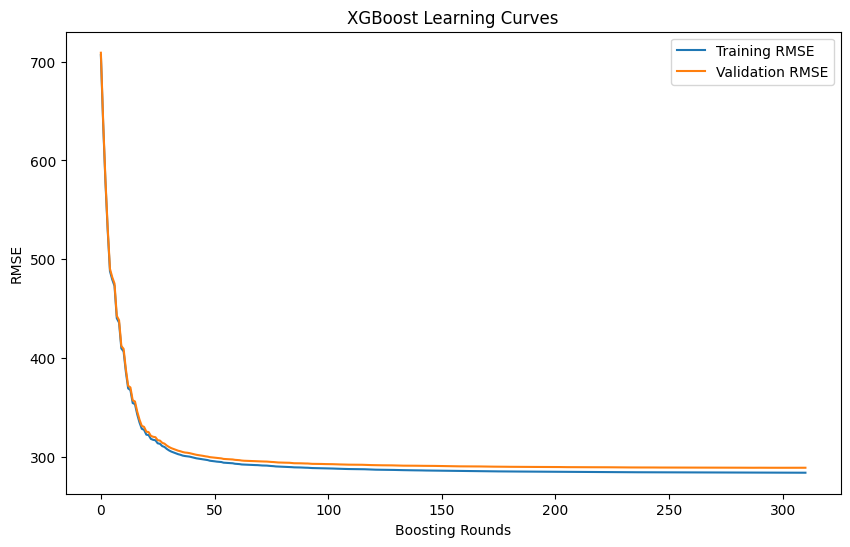

In [15]:
# Plot learning curves
train_scores = best_xgb_model.evals_result()['validation_0']['rmse']
val_scores = best_xgb_model.evals_result()['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_scores, label='Training RMSE')
plt.plot(val_scores, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.show()

## Evaluating the model

In [16]:
# Make predictions on the validation set
y_val_pred = best_xgb_model.predict(X_val_scaled)

In [17]:
# Calculate R2 score and RMSE for validation set
r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Validation Set Metrics with Best Model:")
print(f"R2 Score: {r2_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

Validation Set Metrics with Best Model:
R2 Score: 0.8409
RMSE: 289.1317


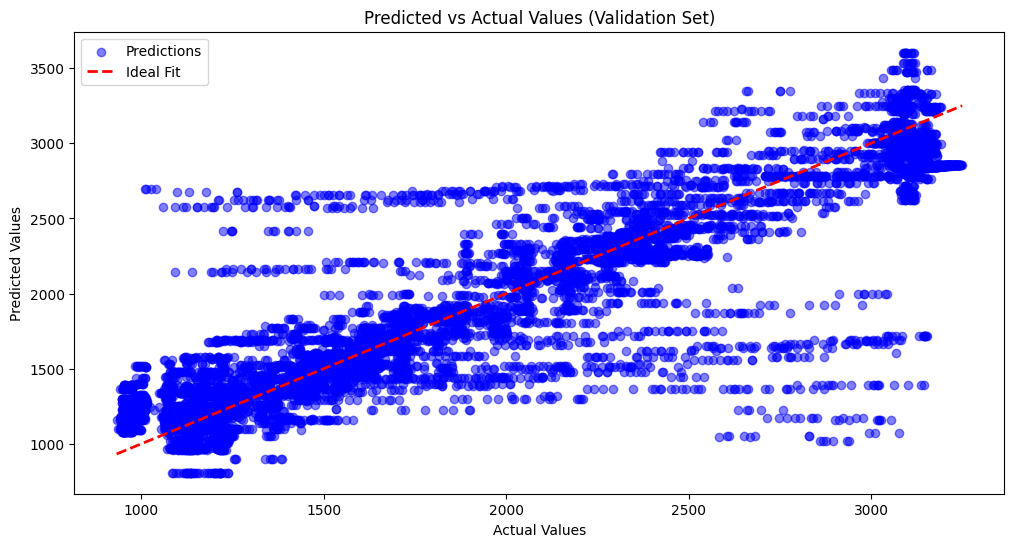

In [18]:
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Validation Set)')
plt.legend()
plt.show()

## Model Evaluation on test data

In [19]:
# Make predictions on the test set
test_data['el_power_predicted'] = best_xgb_model.predict(X_test_scaled)

In [20]:
# Actual vs predicted values
y_test_actual = test_data['el_power']
y_test_pred = test_data['el_power_predicted']

In [21]:
# Calculate R² score for test set
r2_test = r2_score(y_test_actual, y_test_pred)

In [22]:
# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

In [23]:
# Calculate MAE for test set
mae_test = mean_absolute_error(y_test_actual, y_test_pred)

In [24]:
# Print the evaluation metrics for the test set
print("Test Set Evaluation Metrics with Best Model:")
print(f"R² Score: {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")

Test Set Evaluation Metrics with Best Model:
R² Score: 0.8048
RMSE: 326.9103
MAE: 198.9039


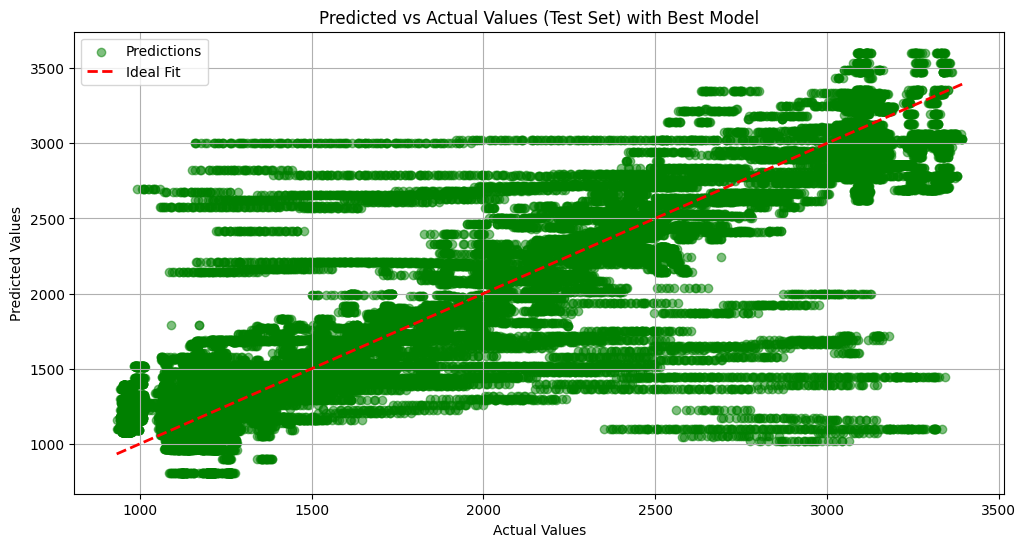

In [25]:
# Plot actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.scatter(y_test_actual, y_test_pred, alpha=0.5, color='green', label='Predictions')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set) with Best Model')
plt.legend()
plt.grid(True)
plt.show()